## Avaliação em holdouts - Amazon Books

Interactions in the 'Amazon Books' dataset are well distributed.
Several users are present during the whole considered period (2014):
<!-- * 37067 users of 190248 (19.484%) occurr in 80.0% or more months. -->
* 292 users of 325 (89.846%) occurr in 80.0% or more months.

In [1]:
import os
import sys
sys.path.append(os.path.abspath('') + '/..')

In [2]:
from data import ImplicitData, getBucketsHoldouts
from plot_utils import lineplot_recallxholdout, recall_heatmap
from dataset_evaluation_utils import *
from recommenders_implicit import ISGD, RAISGD, RSISGD  # ISGD framework, BISGD,
from eval_implicit import EvaluateHoldouts, EvaluateAndStore # EvaluateAndStore para guardar estados do modelo e holdouts, a avaliação prequencial de ratings implicitos é opcional, , EvalHoldout

from datetime import datetime
import joblib
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')

___
## BWT FWT

ACC, BWT, e FWT - Lopez-Paz e Ranzato GEM

In [3]:
def avg_recall(results_matrix): # Lopez-Paz e Ranzato GEM 2017
    return np.mean( np.diag(results_matrix) )

def compute_BWT(results_matrix): # Lopez-Paz e Ranzato GEM 2017
    BWT = []
    n_checkpoints = results_matrix.shape[0]
    for T in range(1, n_checkpoints): # 1 means holdout 2, 2 means 3, so on
        Rti = results_matrix.iloc[T, 0:T] # get models performances' on previous holdouts
        Rii = np.diag(results_matrix)[0:T] # get models performances' on their closest holdouts (diagonal)
        E = sum( Rti - Rii ) # future models performances' - performances' of models closest to holdouts (diagonal)
        BWT.append( E/T ) # store average BWT for model
    return BWT, np.mean( BWT ) # return BWT and average BWT for all models

def compute_FWT(results_matrix): # Díaz-Rodriguez et al. 2018
    upper_tri = results_matrix.to_numpy()[np.triu_indices(results_matrix.shape[0], k=1)]
    return np.mean(upper_tri)

___
# Amazon Books
Small subset, ratings only.  
https://nijianmo.github.io/amazon/index.html


### RAISGD

In [4]:
buckets = joblib.load('output/amazonbooks_dump/3rd_sample_buckets.joblib')
holdouts = joblib.load('output/amazonbooks_dump/3rd_sample_holdouts.joblib')

Hyperparameters

In [5]:
num_factors, num_iter, learn_rate, regularization, num_nodes = (100, 8, 0.5, 0.3, 4)

# # define hyperparameters (SAME AS LASTFM)
# num_factors = 160
# num_iter = 4
# learn_rate = 0.5
# regularization = 0.4
# num_nodes = 8

In [6]:
# transforma interações em objeto que contem mappings usuário-itens e item-usuários, contém também métodos de suporte. recebe listas
# stream = ImplicitData(data[user_col], data[item_col])
# O modelo deve ser iniciado com uma lista vazia
empty_stream = ImplicitData([], [])
# Se o stream for passado, ao excluir itens conhecidos o recall é sempre 0. Ao permitir a recomendação de itens já vistos, o recall não é 0.
model = RAISGD(empty_stream, num_factors, num_iter, learn_rate = learn_rate, u_regularization = regularization, i_regularization = regularization, random_seed = 10)

In [7]:
%%time
# 1d 5h 16min 40s
# criamos instancia de EvaluateHoldouts para treinar o modelo e criar checkpoints
eval = EvaluateHoldouts(model=model, buckets=buckets, holdouts=holdouts)

bucket 0
bucket 1
bucket 2
CPU times: user 1h 50min 20s, sys: 6.64 s, total: 1h 50min 26s
Wall time: 1h 58min 39s


In [8]:
%%time
# 13min 5s
eval.Train_Evaluate(N_recommendations=20, exclude_known_items=True, default_user='none')

Holdout 0
Model 0
Holdout 1
Model 0
Model 1
Model 2
Holdout 2
Model 0
Model 1
Model 2
CPU times: user 28min 59s, sys: 42min 20s, total: 1h 11min 20s
Wall time: 13min 5s


In [10]:
rm = eval.results_matrix
df = pd.DataFrame(rm)
df.to_csv('output/amazonbooks_dump/3rd_sample_amazon_books month_bucket RAISGD results.csv', index=False)

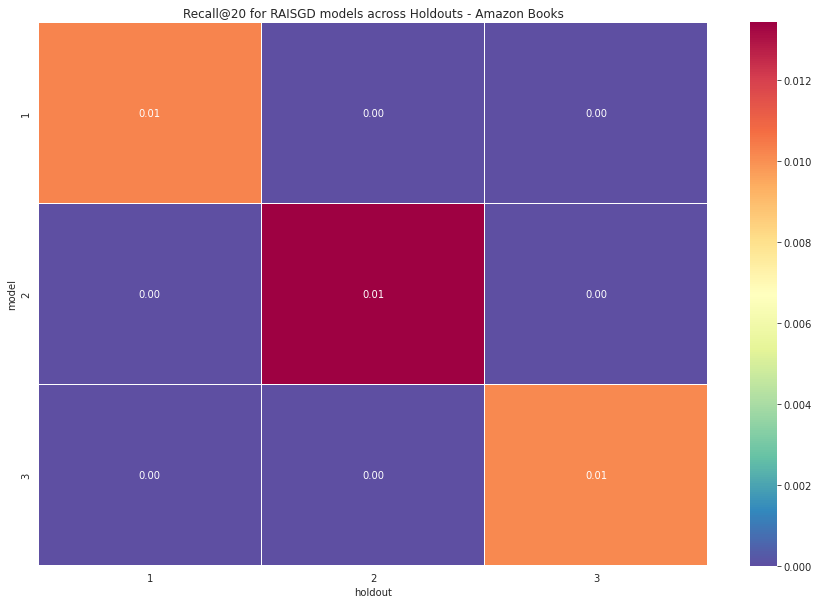

In [11]:
recall_heatmap(df,
    title='Recall@20 for RAISGD models across Holdouts - Amazon Books',
    filepath='images/heatmaps/amazonbooks_dump/3rd_sample_amazon_books month_bucket RAISGD heatmap.png') #='images/heatmaps/palco_2010 month_bucket ISGD heatmap.png'

In [12]:
arecall = avg_recall(df)
arecall

0.011277308843273723

In [13]:
BWT, meanBWT = compute_BWT(df)
BWT, meanBWT

([-0.010273972602739725, -0.011848395697343018], -0.011061184150041372)

In [14]:
FWT = compute_FWT(df)
FWT
# que itens que usuario utilizou no passado e deixou de consumir o sistema ainda pode recomendar

0.0

In [15]:
BWT, meanBWT = compute_BWT(df)
BWT, meanBWT

([-0.010273972602739725, -0.011848395697343018], -0.011061184150041372)

In [16]:
joblib.dump(eval.IncrementalTraining_time_record, 'output/amazonbooks_dump/3rd_sample_amazon_books month_bucket RAISGD training time.joblib')
joblib.dump(eval.EvaluateHoldouts_time_record, 'output/amazonbooks_dump/3rd_sample_amazon_books month_bucket RAISGD eval time.joblib')

['output/amazonbooks_dump/3rd_sample_amazon_books month_bucket RAISGD eval time.joblib']